In [1]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch import t
from CWT.cwt import ComplexMorletCWT

data_dir='./data_spl'
X = torch.load(os.path.join(data_dir, f"train_X_0.pt"))
y = torch.load(os.path.join(data_dir, f"train_y_0.pt"))

画像0を見せた時と100を見せた時の脳波を比較

In [2]:
Z1=X[y==0]
Z2=X[y==100]

In [3]:
Z1.shape

torch.Size([8, 271, 281])

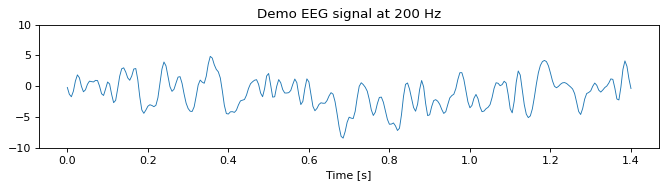

In [4]:
signal=Z1[0].numpy()[0,]
fs = 200

n_samples = signal.size
time_axis = np.arange(0, n_samples) / fs

plt.figure(figsize=(10, 2), dpi=80)
plt.plot(time_axis, signal, linewidth=0.8)
plt.title("Demo EEG signal at %d Hz" % fs)
plt.xlabel("Time [s]")
plt.ylim([-10, 10])
plt.show()

In [5]:
# Parameters CWT
lower_freq = 1
upper_freq = 40
n_scales = 42
wavelet_width = 1

In [6]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales)

In [7]:
print(cwt.frequencies)

[40.         36.55824655 33.41263477 30.53768349 27.91010405 25.50861163
 23.31375282 21.30774809 19.4743477  17.79870012 16.26723168 14.86753666
 13.58827677 12.41908931 11.35050322 10.37386238  9.48125546  8.66545187
  7.91984315  7.23838946  6.61557066  6.04634158  5.52609116  5.05060508
  4.61603164  4.21885057  3.85584448  3.52407283  3.22084808  2.94371396
  2.69042552  2.45893098  2.24735513  2.05398407  1.8772514   1.71572549
  1.56809789  1.43317273  1.30985705  1.19715192  1.09414438  1.        ]


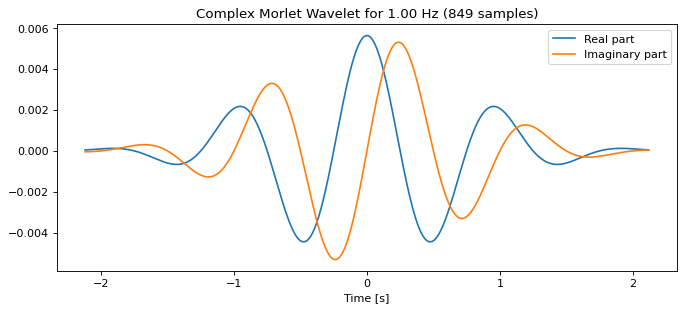

In [8]:
which_scale = -1

real_bank = cwt.real_part
imag_bank = cwt.imaginary_part
single_real_wavelet = real_bank[0, :, 0, which_scale]
single_imag_wavelet = imag_bank[0, :, 0, which_scale]

np_single_real_wavelet = single_real_wavelet.numpy()
np_single_imag_wavelet = single_imag_wavelet.numpy()

single_wavelet_size = np_single_real_wavelet.size
time_axis = np.arange(0, single_wavelet_size) / fs
time_axis = time_axis - np.mean(time_axis)

plt.figure(figsize=(10,4), dpi=80)
plt.plot(time_axis, np_single_real_wavelet, label="Real part")
plt.plot(time_axis, np_single_imag_wavelet, label="Imaginary part")
plt.title("Complex Morlet Wavelet for %1.2f Hz (%d samples)" % (cwt.frequencies[which_scale], single_wavelet_size))
plt.legend()
plt.xlabel("Time [s]")
plt.show()

In [9]:
# reshape and change dtype
prepared_signal = signal.reshape((1, -1, 1)).astype(np.float32)
# compute the scalogram with the created cwt layer
#scalogram = cwt(prepared_signal)
np_scalogram = cwt(prepared_signal).numpy()

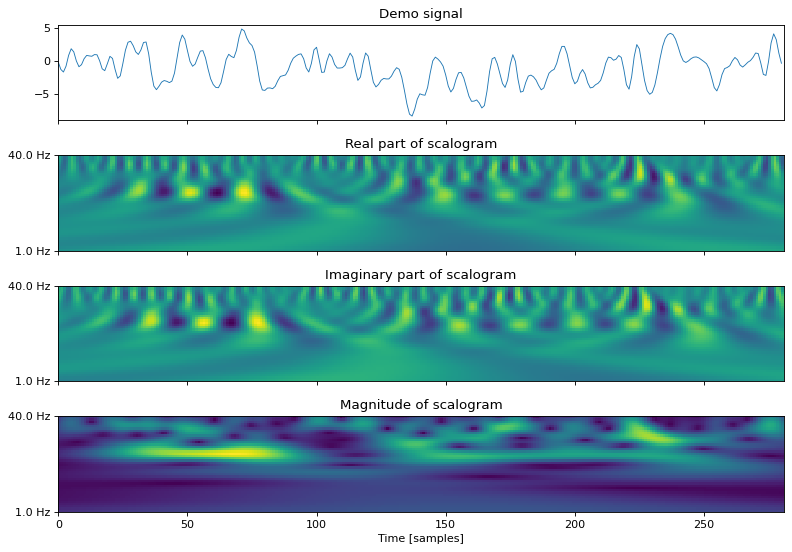

In [10]:
scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(signal, linewidth=0.8)
axes[0].set_title("Demo signal")
axes[1].imshow(scalogram_real.T, interpolation="none", aspect="auto", extent=[0, scalogram_real.shape[0], 0, 1])
axes[1].set_title("Real part of scalogram")
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].imshow(scalogram_imag.T, interpolation="none", aspect="auto", extent=[0, scalogram_imag.shape[0], 0, 1])
axes[2].set_title("Imaginary part of scalogram")
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
axes[3].set_title("Magnitude of scalogram")
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()

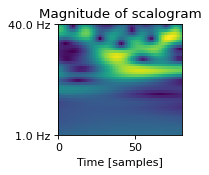

In [11]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=100)
np_scalogram = cwt(prepared_signal).numpy()

scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, ax = plt.subplots(1, 1, figsize=(2, 1.8), dpi=80)
ax.imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.set_title("Magnitude of scalogram")
ax.set_xlabel("Time [samples]")
plt.show()

The result has shape (1, 57, 42, 2)


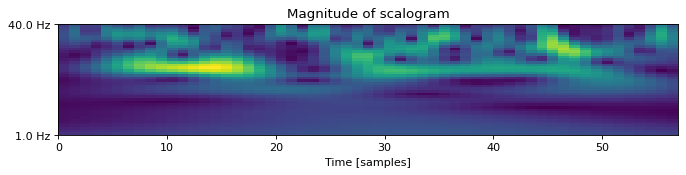

In [12]:
cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=5)
np_scalogram = cwt(prepared_signal).numpy()
print("The result has shape", np_scalogram.shape)

scalogram_real = np_scalogram[0, :, :, 0]
scalogram_imag = np_scalogram[0, :, :, 1]
scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, ax = plt.subplots(1, 1, figsize=(10, 1.8), dpi=80)
ax.imshow(scalogram_magn.T, interpolation="none", aspect="auto", extent=[0, scalogram_magn.shape[0], 0, 1])
ax.set_yticks(chosen_freq_pos)
ax.set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
ax.set_title("Magnitude of scalogram")
ax.set_xlabel("Time [samples]")
plt.show()

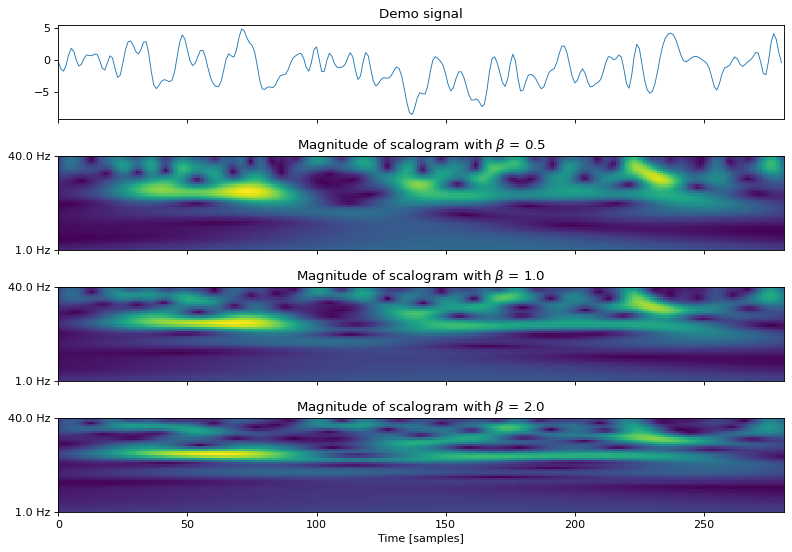

In [13]:
wavelet_width_list = [0.5, 1.0, 2.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    np_scalogram = cwt(prepared_signal).numpy()

    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(signal, linewidth=0.8)
axes[0].set_title("Demo signal")

axes[1].imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[0].shape[0], 0, 1])
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[1].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[0])

axes[2].imshow(
    scalograms_list[1].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[1].shape[0], 0, 1])
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[1])

axes[3].imshow(
    scalograms_list[2].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[2].shape[0], 0, 1])
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[2])

axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()

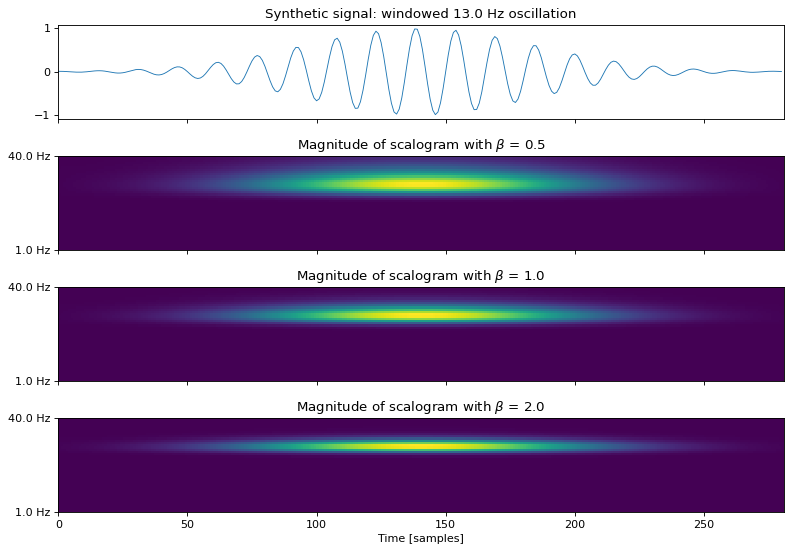

In [14]:
n_samples = 281
central_freq = 13  # Hz
time_axis = np.arange(n_samples) / fs
oscill = np.cos(2 * np.pi * central_freq * time_axis)
window = np.exp(- (time_axis - np.mean(time_axis)) ** 2 / 0.1)
synt_signal = oscill * window 

prepared_synt_signal = synt_signal.reshape((1, -1, 1)).astype(np.float32)

wavelet_width_list = [0.5, 1.0, 2.0]
scalograms_list = []
for wavelet_width in wavelet_width_list:
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=1)
    np_scalogram = cwt(prepared_synt_signal).numpy()
    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalograms_list.append(scalogram_magn)

# useful for y-axis specs
freq_pos = np.linspace(0, 1, n_scales)
freq_val = cwt.frequencies[::-1]
idx_useful = [0, n_scales-1]
chosen_freq_val = freq_val[idx_useful]
chosen_freq_pos = freq_pos[idx_useful]

fig, axes = plt.subplots(4, 1, figsize=(10, 7), dpi=80, sharex=True)
axes[0].plot(synt_signal, linewidth=0.8)
axes[0].set_title("Synthetic signal: windowed %1.1f Hz oscillation" % central_freq)

axes[1].imshow(
    scalograms_list[0].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[0].shape[0], 0, 1])
axes[1].set_yticks(chosen_freq_pos)
axes[1].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[1].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[0])

axes[2].imshow(
    scalograms_list[1].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[1].shape[0], 0, 1])
axes[2].set_yticks(chosen_freq_pos)
axes[2].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[2].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[1])

axes[3].imshow(
    scalograms_list[2].T, interpolation="none", aspect="auto", 
    extent=[0, scalograms_list[2].shape[0], 0, 1])
axes[3].set_yticks(chosen_freq_pos)
axes[3].set_yticklabels(['%1.1f Hz' % f for f in chosen_freq_val])
axes[3].set_title(r"Magnitude of scalogram with $\beta$ = %1.1f" % wavelet_width_list[2])

axes[3].set_xlabel("Time [samples]")
plt.tight_layout()
plt.show()

実装用

In [15]:
def trans(X):
    signal=X
    prepared_signal = signal.reshape((1, -1, 1))
    fs = 200
    # Parameters CWT
    lower_freq = 1
    upper_freq = 40
    n_scales = 42
    wavelet_width = 1
    cwt = ComplexMorletCWT(wavelet_width, fs, lower_freq, upper_freq, n_scales, border_crop=0, stride=5)
    np_scalogram = cwt(prepared_signal)
    print("The result has shape", np_scalogram.shape)

    scalogram_real = np_scalogram[0, :, :, 0]
    scalogram_imag = np_scalogram[0, :, :, 1]
    scalogram_magn = np.sqrt(scalogram_real ** 2 + scalogram_imag ** 2)
    scalogram_magn = torch.tensor(scalogram_magn)
    return scalogram_magn.T


The result has shape (1, 15231, 42, 2)


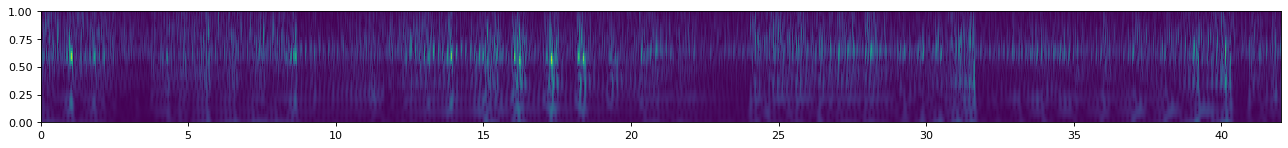

In [16]:
megsig=trans(Z1[0])
plt.subplots(1, 1, figsize=(20, 1.8), dpi=80)
plt.imshow(megsig, interpolation="none", aspect="auto", extent=[0, megsig.shape[0], 0, 1])

In [17]:
megsig.shape

torch.Size([42, 15231])

https://www.kaggle.com/code/anjum48/continuous-wavelet-transform-cwt-in-pytorch

In [18]:
import torch.nn as nn
from scipy import optimize
from timm.layers.conv2d_same import conv2d_same

# From https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py
class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s


class CWT(nn.Module):
    def __init__(
        self,
        dj=0.0625,
        dt=1 / 2048,
        wavelet=Morlet(),
        fmin: int = 20,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
        hop_length: int = 1,
    ):
        super().__init__()
        self.wavelet = wavelet

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, hop_length)
        # self.padding = 0  # "same"

        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    def compute_minimum_scale(self):
        """
        Choose s0 so that the equivalent Fourier period is 2 * dt.
        See Torrence & Combo Sections 3f and 3h.
        :return: float, minimum scale level
        """
        dt = self.dt

        def func_to_solve(s):
            return self.wavelet.fourier_period(s) - 2 * dt

        return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))

        self._pad_filters()

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0]) // 2
            padded_filters.append(nn.functional.pad(f, (pad, pad)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
        # See comment by tez6c32
        # https://www.kaggle.com/anjum48/continuous-wavelet-transform-cwt-in-pytorch/comments#1499878
        # wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank

    def forward(self, x):
        """Compute CWT arrays from a batch of multi-channel inputs

        Args:
            x (torch.tensor): Tensor of shape (batch_size, channels, time)

        Returns:
            torch.tensor: Tensor of shape (batch_size, channels, widths, time)
        """
        if self.signal_length is None:
            self.signal_length = x.shape[-1]
            self.channels = x.shape[-2]
            self._scales = self.compute_optimal_scales()
            self._kernel = self._build_wavelet_bank()

            if self._kernel.is_complex():
                self._kernel_real = self._kernel.real
                self._kernel_imag = self._kernel.imag

        x = x.unsqueeze(1)

        if self._kernel.is_complex():
            if (
                x.dtype != self._kernel_real.dtype
                or x.device != self._kernel_real.device
            ):
                self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
                self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

            # Strides > 1 not yet supported for "same" padding
            # output_real = nn.functional.conv2d(
            #     x, self._kernel_real, padding=self.padding, stride=self.stride
            # )
            # output_imag = nn.functional.conv2d(
            #     x, self._kernel_imag, padding=self.padding, stride=self.stride
            # )
            output_real = conv2d_same(x, self._kernel_real, stride=self.stride)
            output_imag = conv2d_same(x, self._kernel_imag, stride=self.stride)
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)

            if self.output_format == "Magnitude":
                return torch.sqrt(output_real ** 2 + output_imag ** 2)
            else:
                return torch.stack([output_real, output_imag], -1)

        else:
            if x.device != self._kernel.device:
                self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

            # output = nn.functional.conv2d(
            #     x, self._kernel, padding=self.padding, stride=self.stride
            # )
            output = conv2d_same(x, self._kernel, stride=self.stride)
            return torch.transpose(output, 1, 2)

torch.Size([1, 271, 281])
torch.Size([271, 85, 281])


Text(0, 0.5, 'Frequency(Hz)')

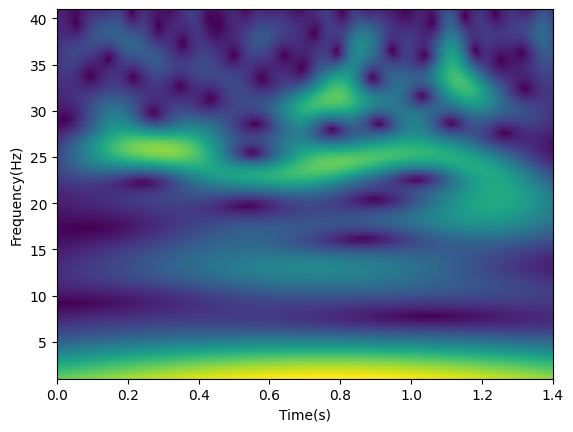

In [21]:
sig_w=Z1[0]
#x_ten = torch.tensor(sig_w, dtype=torch.float32).unsqueeze(0)
x_ten = sig_w.unsqueeze(0)
print(x_ten.shape)

pycwt = CWT(fmin=1, fmax=40, hop_length=1, dt=1/200)  # hop_length=5は時間軸だけでなくch方向もスキップされるので注意
out = pycwt(x_ten).squeeze(0)
print(out.shape)

plt.imshow(out[1, ].numpy(), aspect="auto", extent=[0, 1.4, 1, 41])
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')

C:\Users\senda\AppData\Local\Temp\ipykernel_19196\4072568299.py:7: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = signal.cwt(sig, signal.ricker, widths)


Text(0, 0.5, 'Frequency(Hz)')

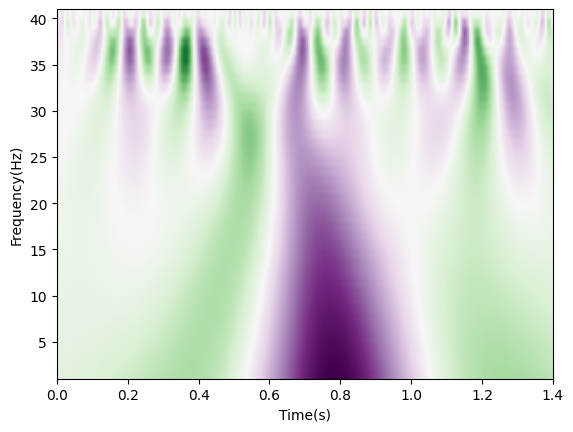

In [22]:
from scipy import signal
t = np.linspace(0, 1.4, 281, endpoint=False)
sig=Z1[0][0,]
#sig = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
widths = np.arange(1, 41)

cwtmatr = signal.cwt(sig, signal.ricker, widths)

plt.imshow(
    cwtmatr,
    extent=[0, 1.4, 1, 41],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(cwtmatr).max(),
    vmin=-abs(cwtmatr).max(),
)
plt.xlabel('Time(s)')
plt.ylabel('Frequency(Hz)')

Text(0, 0.5, 'Amplitude')

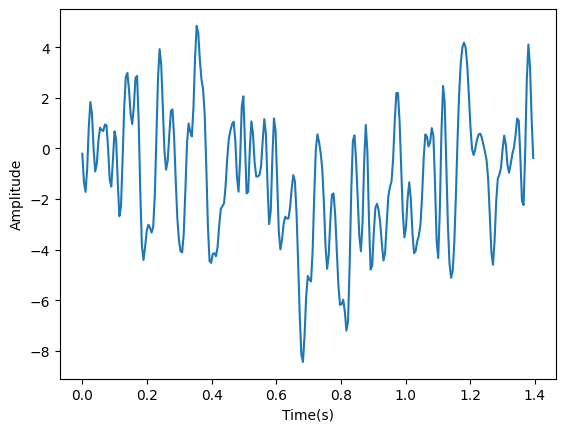

In [23]:
plt.plot(t, sig)
plt.xlabel('Time(s)')
plt.ylabel('Amplitude')

C:\Users\senda\AppData\Local\Temp\ipykernel_19196\1821970094.py:1: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwtmatr = signal.cwt(sig, signal.morlet2, widths)


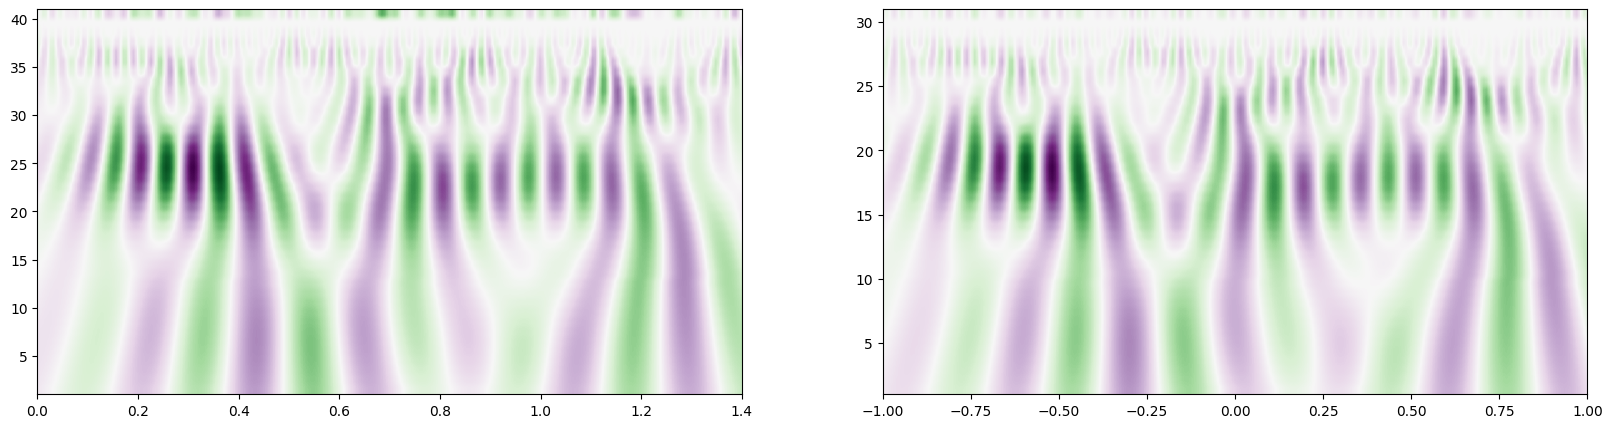

In [24]:
cwtmatr = signal.cwt(sig, signal.morlet2, widths)

real, imag = np.real(cwtmatr), np.imag(cwtmatr)

# Plot the real & imaginary components after CWT using a complex Morlet wavelet
fig, axes = plt.subplots(ncols=2, figsize=(20, 5))
axes[0].imshow(
    real,
    extent=[0, 1.4, 1, 41],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(real).max(),
    vmin=-abs(real).max(),
)
axes[1].imshow(
    imag,
    extent=[-1, 1, 1, 31],
    cmap="PRGn",
    aspect="auto",
    vmax=abs(imag).max(),
    vmin=-abs(imag).max(),
)

In [25]:
import torch
from torch import nn
from einops.layers.torch import Rearrange
from src.models2D import BasicConvClassifier2D
import torch.nn.functional as F

sig_w=Z1[0]
#x_ten = torch.tensor(sig_w, dtype=torch.float32).unsqueeze(0)
x = sig_w.unsqueeze(0)
print(x_ten.shape)
pycwt = CWT(fmin=1, fmax=40, hop_length=1, dt=1/200)  # 271,85,281
x = pycwt(x)#.squeeze(0)  #mainの実行時は batch size=128,271,85,281になるためsqueeze(0)はいらない
print(x.shape)

#x=torch.randn(32,64,128,256)
#x=torch.randn(1,271,81,281)

b0=nn.Conv2d(271, 256, 3, padding="same")
b1=nn.BatchNorm2d(num_features=256)

s1=nn.AdaptiveAvgPool2d(1)
s2=Rearrange("b d 1 1 -> b d")
s3=nn.Linear(256, 1024)

print(x.shape)

y=b0(x)
print(y.shape)
y=b1(y)
print(y.shape)
y=F.gelu(y)
print(y.shape)

y=s1(y)
print(y.shape)
y=s2(y)
print(y.shape)
y=s3(y)
print(y.shape)


torch.Size([1, 271, 281])
torch.Size([1, 271, 85, 281])
torch.Size([1, 271, 85, 281])
torch.Size([1, 256, 85, 281])
torch.Size([1, 256, 85, 281])
torch.Size([1, 256, 85, 281])
torch.Size([1, 256, 1, 1])
torch.Size([1, 256])
torch.Size([1, 1024])
